In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
print(data)

       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


In [4]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
print(data.head())

       Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121


In [5]:
data.columns = ['Date','Passengers']
data.head()

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


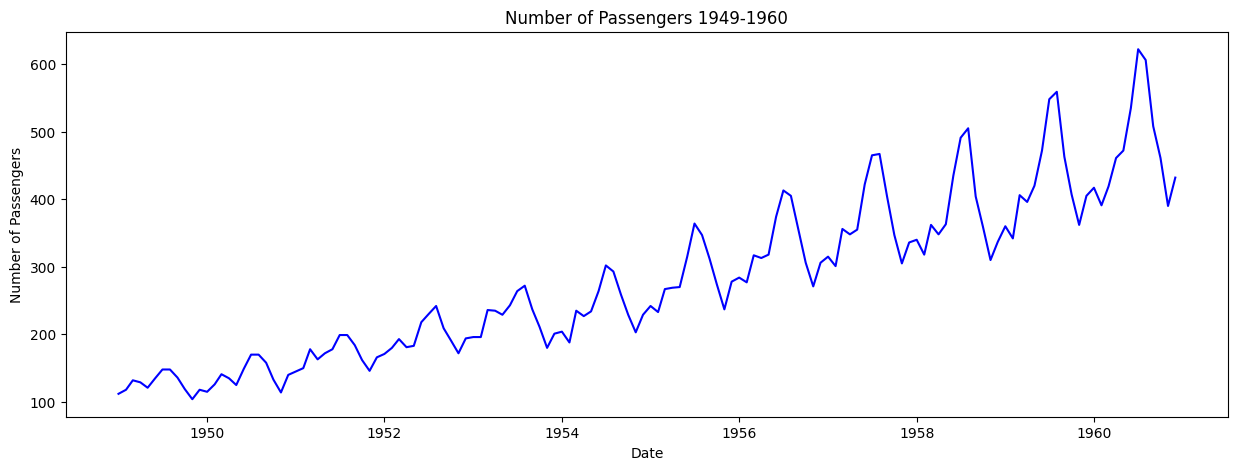

In [6]:
def plot_data(data, x, y, title, xlabel='Date', ylabel='Number of Passengers'): 
    plt.figure(figsize=(15,5))
    plt.plot(x, y, color='blue') 
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_data(data, x=data['Date'], y=data['Passengers'], title='Number of Passengers 1949-1960')

<Figure size 3000x1500 with 0 Axes>

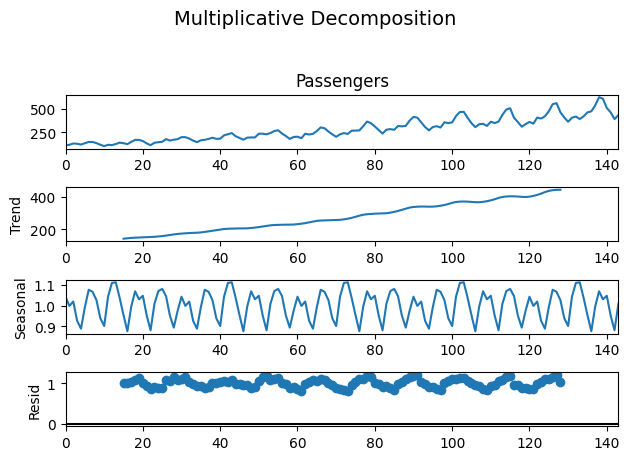

In [7]:
# decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 

multiplicative_decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=30)
plt.figure(figsize=(30,15))
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

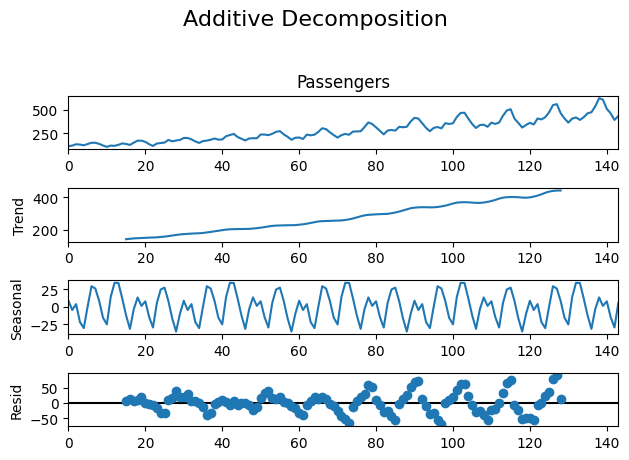

In [8]:
# Additive Decomposition

additive_decomposition = seasonal_decompose(data['Passengers'], model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

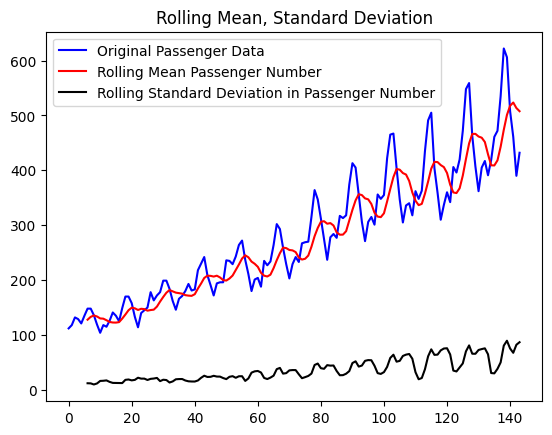

In [9]:
rolling_mean = data['Passengers'].rolling(7).mean()
rolling_std = data['Passengers'].rolling(7).std()

plt.plot(data['Passengers'], color="blue", label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [10]:
# Перевірка на стаціонарність

from statsmodels.tsa.stattools import adfuller

# ADF Test (Розширений тест Дікі Фуллера) 

result = adfuller(data.Passengers.values, autolag='AIC')
print(f'ADF-статистика: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Критичні значення:')
    print(f'   {key}, {value}')

ADF-статистика: 0.8153688792060482
p-value: 0.991880243437641
Критичні значення:
   1%, -3.4816817173418295
Критичні значення:
   5%, -2.8840418343195267
Критичні значення:
   10%, -2.578770059171598


In [11]:
# ADF Test: p>0.05, ряд не стаціонарний

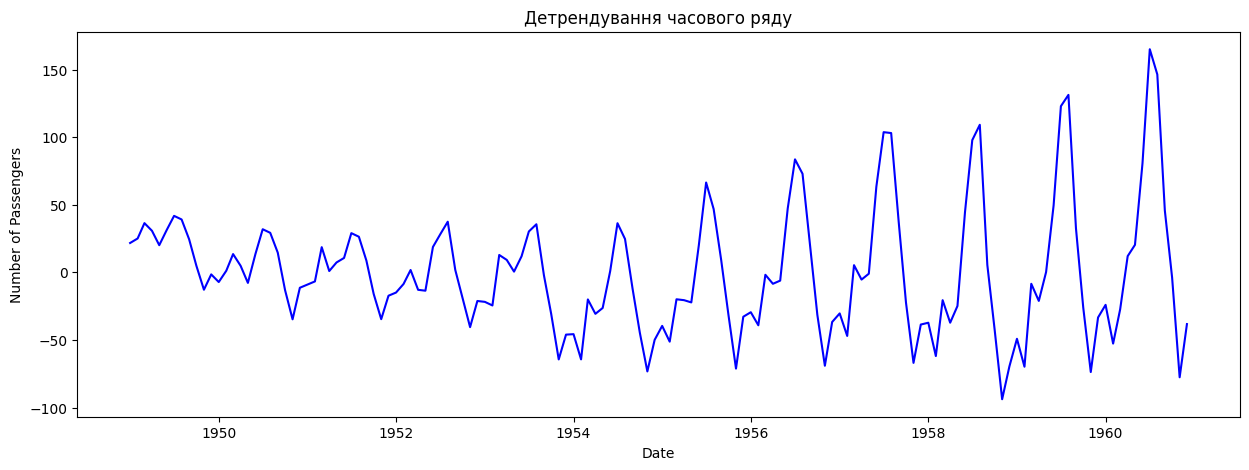

In [12]:
# Детрендування 

from scipy import signal
detrended = signal.detrend(data['Passengers'].values)
plot_data(data, x=data['Date'], y=detrended, title='Детрендування часового ряду')
plt.show()

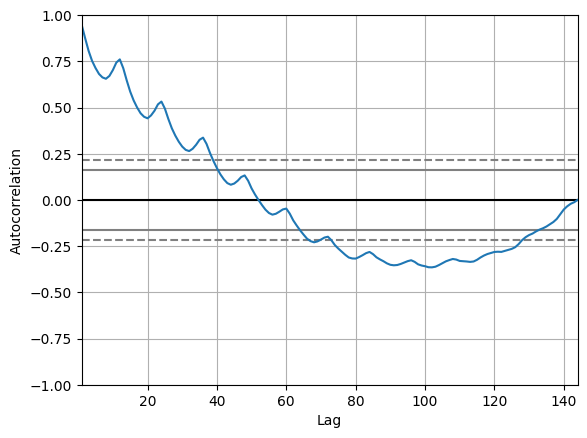

In [13]:
# Тест на сезонність

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Passengers'])
plt.show()

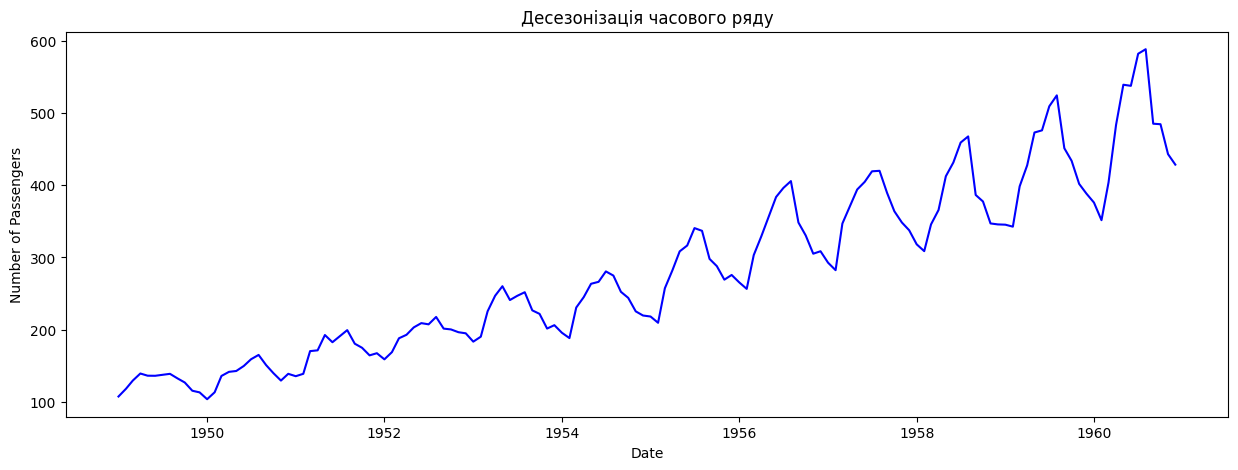

In [14]:
# Десезонізація

multiplicative_decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=30)
deseasonalized = data['Passengers'].values / multiplicative_decomposition.seasonal
plot_data(data, x=data['Date'], y=deseasonalized, title='Десезонізація часового ряду')
plt.show()

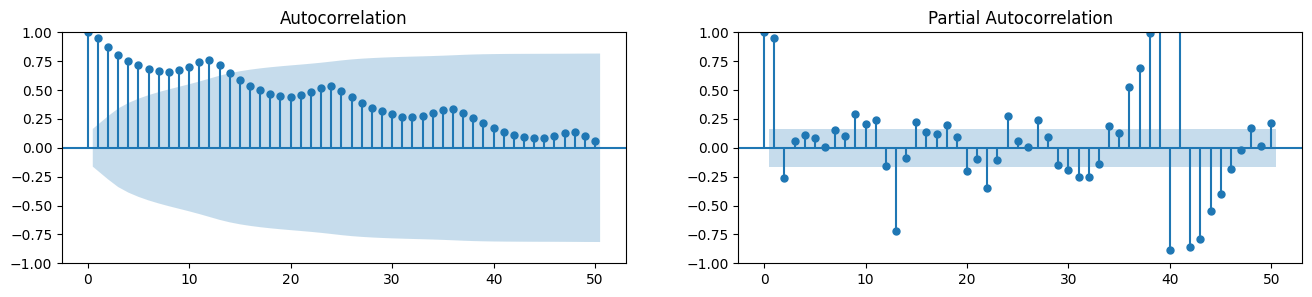

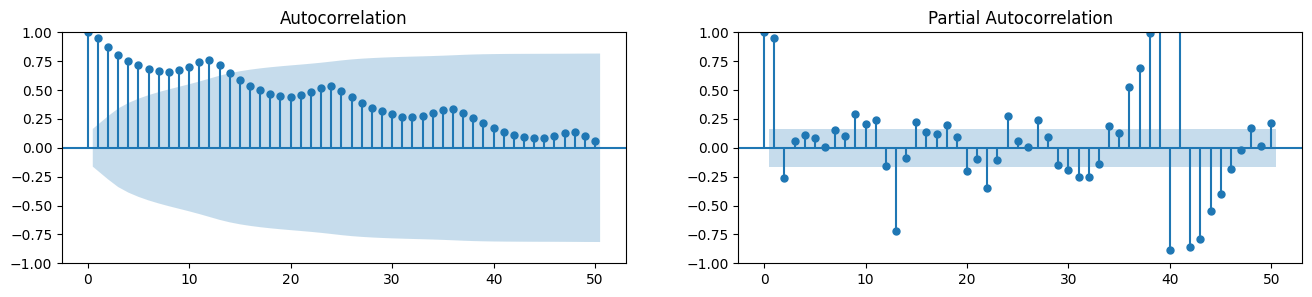

In [15]:
# Автокореляція, часткова автокореляція

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['Passengers'].tolist(), lags=50, ax=axes[0])
plot_pacf(data['Passengers'].tolist(), lags=50, ax=axes[1])

In [16]:
autocorrelation_lag1 = data['Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = data['Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = data['Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = data['Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

autocorrelation_lag12 = data['Passengers'].autocorr(lag=12)
print("Twelve Month Lag: ", autocorrelation_lag12)

One Month Lag:  0.9601946480498522
Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167602
Twelve Month Lag:  0.9905273692085446


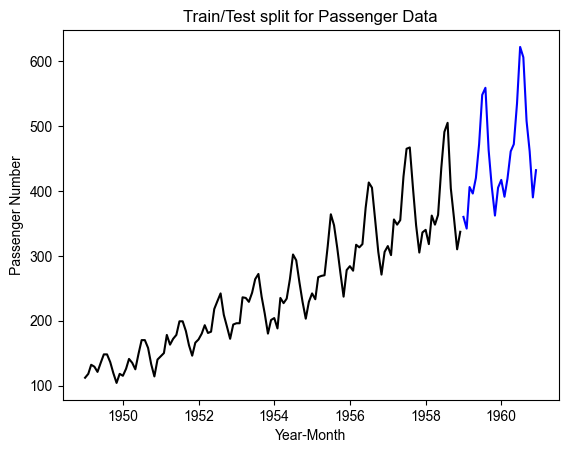

In [17]:
# forecasting


data.index = data['Date']
del data['Date']
data['Date'] = data.index

train = data[data['Date'] < pd.to_datetime("1959-01-01", format='%Y-%m')]
train['Train'] = train['Passengers']
del train['Date']
del train['Passengers']

test = data[data['Date'] >= pd.to_datetime("1959-01-01", format='%Y-%m')]
test['Test'] = test['Passengers']
del test['Date']
del test['Passengers']

plt.plot(train, color = "black")
plt.plot(test, color = "blue")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [18]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1087.029, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1140.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1132.336, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.668, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1138.809, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1126.948, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 3.545 seco

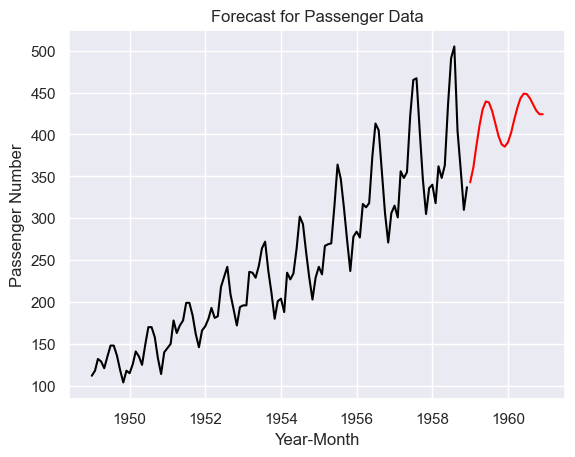

In [19]:
plt.plot(train, color = "black")
plt.plot(forecast, color = "red")
plt.title("Forecast for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [20]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(test,forecast))
print("root mean squared error (RMSE): ", rms)

root mean squared error (RMSE):  67.60311342507471
